In [3]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np

sys.path.append(os.environ['DH_DIR'])
from darkhistory.spec.spectrum import Spectrum

In [66]:
from astropy.cosmology import Planck18

sys.path.append("..")
from dm21cm.data_cacher import Cacher as XRayCacher
from dm21cm.profiler import Profiler


In [74]:
profiler = Profiler()
xray_cacher = XRayCacher(data_path='tmp.h5', cosmo=Planck18, N=64, dx=2.)
rs = 300.
eng = np.geomspace(1e-4, 1e12, 500)
for i in range(200):
    s = Spectrum(eng, 10**np.random.uniform(-10, 10, 500), spec_type='N', rs=rs)
    xray_cacher.spectrum_cache.cache_spectrum(s, rs-1)
    attenuation_arr = np.full((500,), 0.95)
    rs -= 1.
    profiler.start()
    xray_cacher.advance_spectrum(attenuation_arr, rs-1)
    profiler.record('advance')

<Axes: xlabel='Iteration', ylabel='Time [s]'>

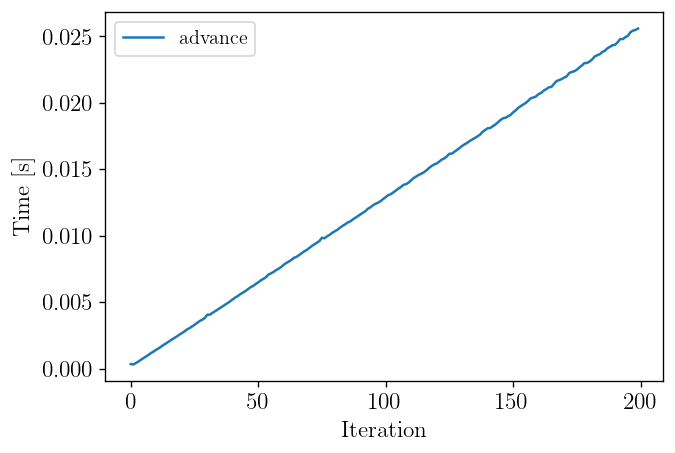

In [75]:
profiler.plot()

In [76]:
def f():
    profiler = Profiler()
    xray_cacher = XRayCacher(data_path='tmp.h5', cosmo=Planck18, N=64, dx=2.)
    rs = 300.
    eng = np.geomspace(1e-4, 1e12, 500)
    for i in range(200):
        s = Spectrum(eng, 10**np.random.uniform(-10, 10, 500), spec_type='N', rs=rs)
        xray_cacher.spectrum_cache.cache_spectrum(s, rs-1)
        attenuation_arr = np.full((500,), 0.95)
        rs -= 1.
        profiler.start()
        xray_cacher.advance_spectrum(attenuation_arr, rs-1)
        profiler.record('advance')

In [78]:
import cProfile
import pstats

In [79]:
profiler = cProfile.Profile()
profiler.enable()
f()
profiler.disable()

In [84]:
fn = f"{os.environ['P21C_CACHE_DIR']}/test_elec/xray_brightness.h5"

In [85]:
import h5py

In [ ]:
os.listdir(os.environ['P21C_CACHE_DIR']+'/test_elec')

In [80]:
stats = pstats.Stats(profiler).sort_stats('cumulative')

stats.print_stats(50)

         3654168 function calls (3654153 primitive calls) in 4.047 seconds

   Ordered by: cumulative time
   List reduced from 470 to 50 due to restriction <50>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    4.047    2.023 /n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3490(run_code)
        2    0.000    0.000    4.047    2.023 {built-in method builtins.exec}
        1    0.003    0.003    4.047    4.047 /tmp/ipykernel_1144794/2561460246.py:1(f)
      200    0.000    0.000    4.024    0.020 /n/home07/yitians/dm21cm/DM21cm/benchmarking/../dm21cm/data_cacher.py:49(advance_spectrum)
      200    0.015    0.000    3.994    0.020 /n/home07/yitians/dm21cm/DM21cm/benchmarking/../dm21cm/data_cacher.py:123(redshift)
    20100    0.108    0.000    3.979    0.000 /n/home07/yitians/darkhistory/DarkHistory/darkhistory/spec/spectrum.py:1136(redshift)
    20100    1.138    0.000    3.871    

In [50]:
class NewSpectrum (Spectrum):

    def redshift_fast(self, new_rs):
        if self.rs <= 0:
            raise ValueError('self.rs must be initialized.')

        fac = new_rs/self.rs

        eng_orig = self.eng

        self.eng = self.eng*fac
        if self._spec_type == 'dNdE':
            self.dNdE = self.dNdE/fac
        self.underflow['eng'] *= fac

        self.rebin_fast(eng_orig)
        self.rs = new_rs

    def redshift_faster(self, new_rs):
        """Redshifts the :class:`Spectrum` object as a photon spectrum fast.

        Parameters
        ----------
        new_rs : float
            The new redshift (1+z) to redshift to.
        """
        if self.rs < 0:
            raise ValueError('Redshift must be set.')
        if self.spec_type == 'dNdE':
            raise NotImplementedError('Spectrum must be in N.')
        
        eng_extended = np.insert(self.eng, 0, self.eng[0]**2/self.eng[1]) # prepend eng log-symmetrically
        dN = self._data * (1 - new_rs/self.rs) * self.eng / np.diff(eng_extended)
        self._data -= dN
        self._data[:-1] += dN[1:]
        self.underflow['N'] += dN[0]
        self.underflow['eng'] += dN[0] * eng_extended[0]
        self.rs = new_rs

In [54]:
eng = np.linspace(2, 200, 500)
N = np.random.uniform(-10, 10, 500)
underflow = {'N': np.random.uniform(), 'eng': np.random.uniform()}
rs = 10.

spec0 = NewSpectrum(eng, N, rs=rs, spec_type='N')
spec0.underflow = underflow
spec1 = NewSpectrum(eng, N, rs=rs, spec_type='N')
spec1.underflow = underflow
spec2 = NewSpectrum(eng, N, rs=rs, spec_type='N')
spec2.underflow = underflow

In [59]:
s = Spectrum(np.array([1., 2., 3.]), np.array([0., 0., 1.]), rs=5, spec_type='N')

In [60]:
s.N *= 2
s

In [61]:
s.N

array([0., 0., 2.])

In [55]:
def f0():
    spec1.rs = 10.
    spec1.redshift(8.)

In [56]:
%timeit f0()

127 µs ± 67.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [57]:
def f0_fast():
    spec1.rs = 10.
    spec1.redshift_fast(8.)

In [58]:
%timeit f0_fast()

107 µs ± 63.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [45]:
spec2.redshift_fast(8.)

In [46]:
spec1.toteng()

81.9690458077649

In [47]:
spec2.toteng()

81.96904580776491

In [ ]:
spec1.toteng()

102.78223016509136

In [ ]:
spec2.toteng()

102.78223016509136

In [48]:
np.isclose(spec1._data, spec2._data)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
import matplotlib.pyplot as plt

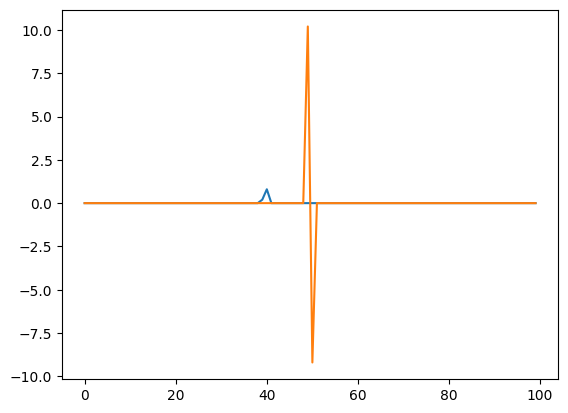

In [49]:
plt.plot(spec1._data)
plt.plot(spec2._data)